In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

In [2]:
df = pd.read_csv('df_scaled.csv')

In [3]:
df['track_popularity'].head()

0    0.617978
1    0.629213
2    0.662921
3    0.550562
4    0.651685
Name: track_popularity, dtype: float64

In [8]:
import pickle  #


df = pd.read_csv('df_scaled.csv')


numerical_features = ['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
X = df[numerical_features].values
y = df['track_popularity'].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


class MusicNet(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, output_size):
        super(MusicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(p=dropout_rate)  # Dropout 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(p=dropout_rate)  # Dropout 
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  
        x = self.fc3(x)
        return x

# Grid search
learning_rates = [0.001, 0.01]
hidden_sizes = [64, 128]
dropout_rates = [0.3, 0.5]

best_test_loss = float('inf')
best_model = None
test_losses = [] 


for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for dropout_rate in dropout_rates:
            print(f"Training with lr={lr}, hidden_size={hidden_size}, dropout_rate={dropout_rate}")

            
            input_size = X_train.shape[1]
            output_size = 1  
            model = MusicNet(input_size, hidden_size, dropout_rate, output_size)
            loss_fn = nn.MSELoss()  
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

            
            epochs = 20
            for epoch in range(epochs):
                model.train()  
                train_loss = 0
                for X_batch, y_batch in train_dataloader:
                    optimizer.zero_grad()  
                    y_pred = model(X_batch).squeeze()
                    loss = loss_fn(y_pred, y_batch)
                    loss.backward()        
                    optimizer.step()       
                    train_loss += loss.item()

                avg_train_loss = train_loss / len(train_dataloader)

                
                model.eval()  
                test_loss = 0
                with torch.no_grad():  
                    for X_batch, y_batch in test_dataloader:
                        y_pred = model(X_batch).squeeze()
                        loss = loss_fn(y_pred, y_batch)
                        test_loss += loss.item()

                avg_test_loss = test_loss / len(test_dataloader)
                test_losses.append(avg_test_loss)  
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

                
                scheduler.step(avg_test_loss)

            
            if avg_test_loss < best_test_loss:
                best_test_loss = avg_test_loss
                best_model = model
                print(f"Nuevo mejor modelo encontrado: Test Loss = {best_test_loss:.4f}")

if best_model is not None:
    save_data = {
        'model_state_dict': best_model.state_dict(),
        'test_losses': test_losses
    }
    model_save_path = "best_musicnet_model.pkl"
    with open(model_save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"Mejor modelo y test loss guardado: {model_save_path}")

Training with lr=0.001, hidden_size=64, dropout_rate=0.3


c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/20, Train Loss: 0.0470, Test Loss: 0.0374
Epoch 2/20, Train Loss: 0.0399, Test Loss: 0.0374
Epoch 3/20, Train Loss: 0.0388, Test Loss: 0.0372
Epoch 4/20, Train Loss: 0.0383, Test Loss: 0.0372
Epoch 5/20, Train Loss: 0.0380, Test Loss: 0.0369
Epoch 6/20, Train Loss: 0.0379, Test Loss: 0.0367
Epoch 7/20, Train Loss: 0.0377, Test Loss: 0.0367
Epoch 8/20, Train Loss: 0.0377, Test Loss: 0.0367
Epoch 9/20, Train Loss: 0.0377, Test Loss: 0.0367
Epoch 10/20, Train Loss: 0.0375, Test Loss: 0.0366
Epoch 11/20, Train Loss: 0.0375, Test Loss: 0.0366
Epoch 12/20, Train Loss: 0.0374, Test Loss: 0.0368
Epoch 13/20, Train Loss: 0.0375, Test Loss: 0.0366
Epoch 14/20, Train Loss: 0.0374, Test Loss: 0.0365
Epoch 15/20, Train Loss: 0.0374, Test Loss: 0.0367
Epoch 16/20, Train Loss: 0.0374, Test Loss: 0.0364
Epoch 17/20, Train Loss: 0.0374, Test Loss: 0.0367
Epoch 18/20, Train Loss: 0.0374, Test Loss: 0.0367
Epoch 19/20, Train Loss: 0.0373, Test Loss: 0.0365
Epoch 20/20, Train Loss: 0.0373, Test Lo

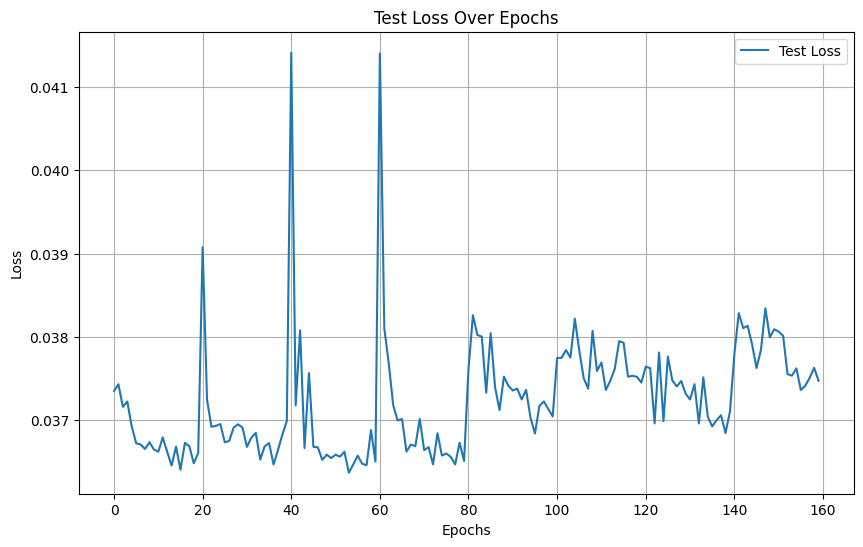

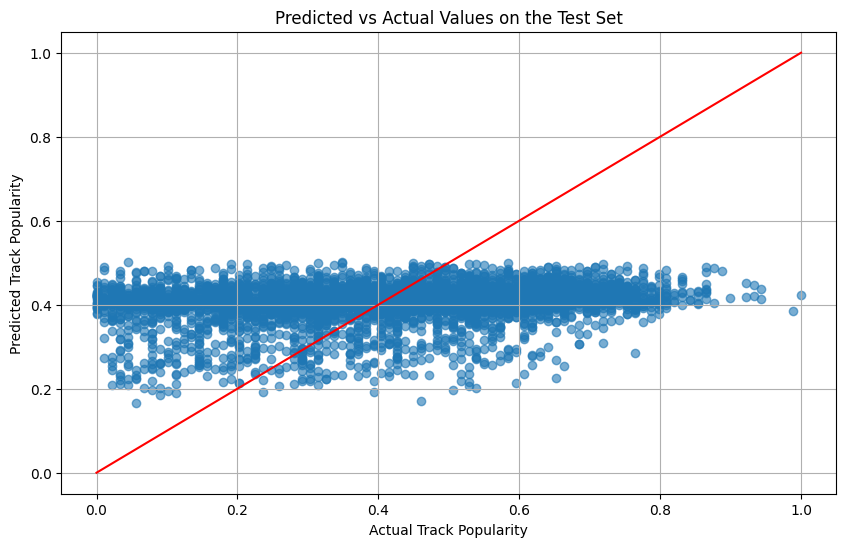

In [14]:
# Plotting Test Losses over Epochs
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label="Test Loss")
plt.title("Test Loss sobre Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        y_pred = best_model(X_test_tensor).squeeze().numpy()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  
    plt.title("Predicted vs Actual Values en el Test Set")
    plt.xlabel("Track Popularity real")
    plt.ylabel("Track Popularity predecido")
    plt.grid(True)
    plt.show()

In [15]:
import math

rmse = math.sqrt(avg_test_loss)
print(f"RMSE: {rmse:.4f}")


RMSE: 0.1936


In [7]:

numerical_features_2 = ['acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo']

X = df[numerical_features_2].values
y = df['track_popularity'].values  # Target track_popularity


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
#modelo 2
class MusicNet_2(nn.Module):
    def __init__(self, input_size, output_size):
        super(MusicNet_2, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_size = X_train.shape[1]
output_size = 1  

model = MusicNet_2(input_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)
test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       
        train_loss += loss.item()

        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval() 
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss) 
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1
-------------------------------
Batch 0, Loss: 0.10246619582176208
Batch 400, Loss: 0.033541928976774216
Train Loss: 0.0410
Test Loss: 0.0372
Epoch 2
-------------------------------
Batch 0, Loss: 0.04095844179391861
Batch 400, Loss: 0.04852212965488434
Train Loss: 0.0384
Test Loss: 0.0370
Epoch 3
-------------------------------
Batch 0, Loss: 0.0437997467815876
Batch 400, Loss: 0.024035772308707237
Train Loss: 0.0381
Test Loss: 0.0376
Epoch 4
-------------------------------
Batch 0, Loss: 0.03354320302605629
Batch 400, Loss: 0.022595085203647614
Train Loss: 0.0380
Test Loss: 0.0376
Epoch 5
-------------------------------
Batch 0, Loss: 0.04426751285791397
Batch 400, Loss: 0.03203750401735306
Train Loss: 0.0380
Test Loss: 0.0375
Epoch 6
-------------------------------
Batch 0, Loss: 0.04275990650057793
Batch 400, Loss: 0.02853943593800068
Train Loss: 0.0380
Test Loss: 0.0385
Epoch 7
-------------------------------
Batch 0, Loss: 0.04056654870510101
Batch 400, Loss: 0.0387053973

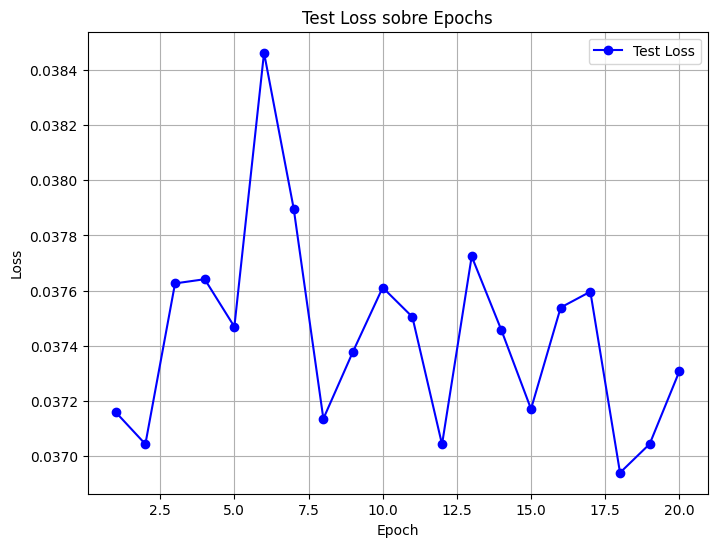

In [9]:
import matplotlib.pyplot as plt


epochs_list = list(range(1, epochs + 1))


plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
rmse = math.sqrt(avg_test_loss)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1932


In [11]:
df_pca = pd.read_csv('df_pca9.csv')

In [12]:
df_pca.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,track_id,track_popularity
0,-1.228247,-2.007737,0.636795,-1.357469,-1.137151,-1.301107,-0.040412,-0.705792,-0.603308,6f807x0ima9a1j3VPbc7VN,0.617978
1,-0.814656,-1.237786,0.390595,-1.321949,-1.275996,-0.900223,1.379120,0.766448,0.605321,0r7CVbZTWZgbTCYdfa2P31,0.629213
2,-1.380825,-1.835965,0.500640,-1.146859,-1.218530,-1.204166,-0.001245,-0.475784,-0.197209,1z1Hg7Vb0AhHDiEmnDE79l,0.662921
3,-1.276420,-1.840713,1.212820,-0.632802,-1.227607,-0.654282,0.240339,0.151130,-0.227065,75FpbthrwQmzHlBJLuGdC7,0.550562
4,-1.036401,-1.130778,0.537385,-1.468597,-1.034739,-1.504985,-0.175239,-0.388876,0.052818,1e8PAfcKUYoKkxPhrHqw4x,0.651685


In [13]:

numerical_features = ['PC0', 'PC1', 'PC2', 
                      'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']

X = df_pca[numerical_features].values
y = df_pca['track_popularity'].values  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Deje este escalado estandar porque mejora los resultados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Conversion a tensores de pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modelo 1
class MusicNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(MusicNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


input_size = X_train.shape[1]
output_size = 1  

model = MusicNet(input_size, output_size)
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
test_losses = []

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = 0
    model.train()  
    
    for batch, (X_batch, y_batch) in enumerate(train_dataloader):
        
        # Forward pass
        y_pred = model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       

        train_loss += loss.item()

        if batch % 400 == 0:
            print(f"Batch {batch}, Loss: {loss.item()}")
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Evaluation Loop
    model.eval()  
    test_loss = 0
    
    with torch.no_grad():  
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)  
    print(f"Test Loss: {avg_test_loss:.4f}")


Epoch 1
-------------------------------
Batch 0, Loss: 0.15659567713737488
Batch 400, Loss: 0.04827439412474632
Train Loss: 0.0404
Test Loss: 0.0375
Epoch 2
-------------------------------
Batch 0, Loss: 0.03796084225177765
Batch 400, Loss: 0.034992560744285583
Train Loss: 0.0381
Test Loss: 0.0372
Epoch 3
-------------------------------
Batch 0, Loss: 0.04244299605488777
Batch 400, Loss: 0.04971121624112129
Train Loss: 0.0378
Test Loss: 0.0369
Epoch 4
-------------------------------
Batch 0, Loss: 0.03490537405014038
Batch 400, Loss: 0.04474978893995285
Train Loss: 0.0377
Test Loss: 0.0371
Epoch 5
-------------------------------
Batch 0, Loss: 0.036964815109968185
Batch 400, Loss: 0.028453532606363297
Train Loss: 0.0375
Test Loss: 0.0370
Epoch 6
-------------------------------
Batch 0, Loss: 0.02561306580901146
Batch 400, Loss: 0.029908429831266403
Train Loss: 0.0373
Test Loss: 0.0369
Epoch 7
-------------------------------
Batch 0, Loss: 0.04056328535079956
Batch 400, Loss: 0.03675742

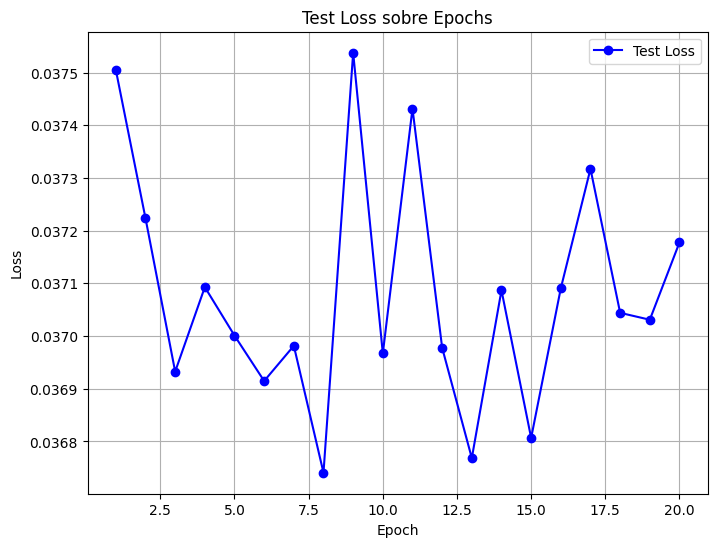

In [14]:
# Plot de los resultados
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title('Test Loss sobre Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:

rmse = math.sqrt(avg_test_loss)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1928
